In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else 
                     "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
features = [
    # 宏观
    'cpi_yoy_off', 
    'ppi_cpi_gap',
    'm2_yoy',
    'macro_momentum',

    # 宏观：流动性
    'repo_rate_7d',
    'cn_10y_repo_spread',
    'vix_ma5_ratio',
    'usd_index_ret5',

    # 中观
    'steel_price_index_ret20',
    'wti_oil_ret20',
    'blast_furnace_rate_mom',

    # 微观
    'hs300_ret1',
    'hs300_vol20',
    'macd_diff',
    'bb_position',
    'rsi_14',
    'turnover_ma10_ratio',
    'margin_change_rate',
    'pe_percentile'
]

target = 'hs300_ret1'

In [4]:
df_all = pd.read_pickle('processed_data.pkl')
panel = df_all[features].copy()

In [5]:
def create_sequences(data, seq_length=30, pred_horizon=5, target='hs300_ret1'):
    feat_cols = [c for c in data.columns if c != target]

    X, y, dates = [], [], []

    for i in range(seq_length, len(data) - pred_horizon):
        window = data[feat_cols].iloc[i-seq_length:i].values
        if np.isnan(window).any():
            continue
        X.append(window)
        
        future_daily_returns = data[target].iloc[i:i+pred_horizon]
        compound_return = (1 + future_daily_returns).prod() - 1
        y.append(compound_return)
        dates.append(data.index[i])

    return np.array(X), np.array(y), dates

In [6]:
train_end = '2023-12-31'
val_start = '2024-01-01'
val_end   = '2024-12-31'

train_data = panel.loc[:train_end]
val_data   = panel.loc[val_start:val_end]
test_data  = panel.loc[val_end:]

X_train, y_train, train_dates = create_sequences(train_data, seq_length=30)
X_val, y_val, val_dates = create_sequences(val_data, seq_length=30)
X_test, y_test, test_dates = create_sequences(test_data, seq_length=30)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (2154, 30, 18), y_train: (2154,)
X_val: (207, 30, 18), y_val: (207,)
X_test: (58, 30, 18), y_test: (58,)


In [7]:
class GRUModel(nn.Module):
    def __init__(self, in_feat, hid=64, n_layers=2, drop=0.2):
        super().__init__()

        self.gru = nn.GRU(
            in_feat, hid,
            n_layers,
            batch_first=True,
            dropout=drop if n_layers > 1 else 0)
            
        self.fc  = nn.Linear(hid, 1)
        self.out_act = nn.Identity()

    def forward(self, x):
        h, _ = self.gru(x)
        y = self.fc(h[:, -1, :])
        return self.out_act(y).squeeze(1)

In [8]:
# 损失: Huber + 0.05·L2_pred

def loss_fn(pred, target):
    huber = nn.functional.smooth_l1_loss(pred, target)
    l2    = 0.05 * (pred ** 2).mean()
    return huber + l2, huber

In [ ]:
# 训练: 含 early stop

def fit(model, loader, X_val, y_val, epochs=60, lr=1e-3, patience=6):
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    history = {'train_loss': [], 'val_loss': [],
               'train_mse': [],  'val_mse': [],
               'val_direction_acc': [], 'pred_mean': [], 'pred_std': []}

    best, wait = 1e9, 0
    for ep in range(1, epochs+1):
        # ---- train ----
        model.train(); tloss = tmse = 0
        for xb, yb in loader:
            opt.zero_grad()
            pred = model(xb)
            loss, huber = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tloss += loss.item()*len(xb)
            tmse  += huber.item()*len(xb)

        tloss /= len(loader.dataset)
        tmse  /= len(loader.dataset)

        # ---- val ----
        model.eval()
        with torch.no_grad():
            vpred = model(X_val)
            vtotal, vhub = loss_fn(vpred, y_val)
            vdir  = (torch.sign(vpred) == torch.sign(y_val)).float().mean().item()
        history['train_loss'].append(tloss)
        history['val_loss'].append(vtotal.item())
        history['train_mse'].append(tmse)
        history['val_mse'].append(vhub.item())
        history['val_direction_acc'].append(vdir)
        history['pred_mean'].append(vpred.mean().item())
        history['pred_std'].append(vpred.std().item())

        print(f'E{ep:02d}  train {tloss:.4f}  val {vhub:.4f}  dir {vdir:.3f}')

        # ---- early-stop ----
        if vhub < best - 1e-6:
            best, wait = vhub, 0
            torch.save(model.state_dict(), 'best_model.pth') 
        else:
            wait += 1
            if wait >= patience:
                print('Early stop'); break
    return history

In [10]:
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32, device=device)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32, device=device)

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)

model = GRUModel(in_feat=X_train.shape[2]).to(device)
history = fit(model, loader, X_val_t, y_val_t, epochs=80, lr=1e-3)

E01  train 0.0027  val 0.0005  dir 0.623
E02  train 0.0006  val 0.0004  dir 0.705
E03  train 0.0005  val 0.0003  dir 0.744
E04  train 0.0004  val 0.0004  dir 0.671
E05  train 0.0003  val 0.0004  dir 0.705
E06  train 0.0003  val 0.0005  dir 0.618
E07  train 0.0003  val 0.0003  dir 0.720
E08  train 0.0003  val 0.0004  dir 0.580
E09  train 0.0003  val 0.0004  dir 0.739
Early stop


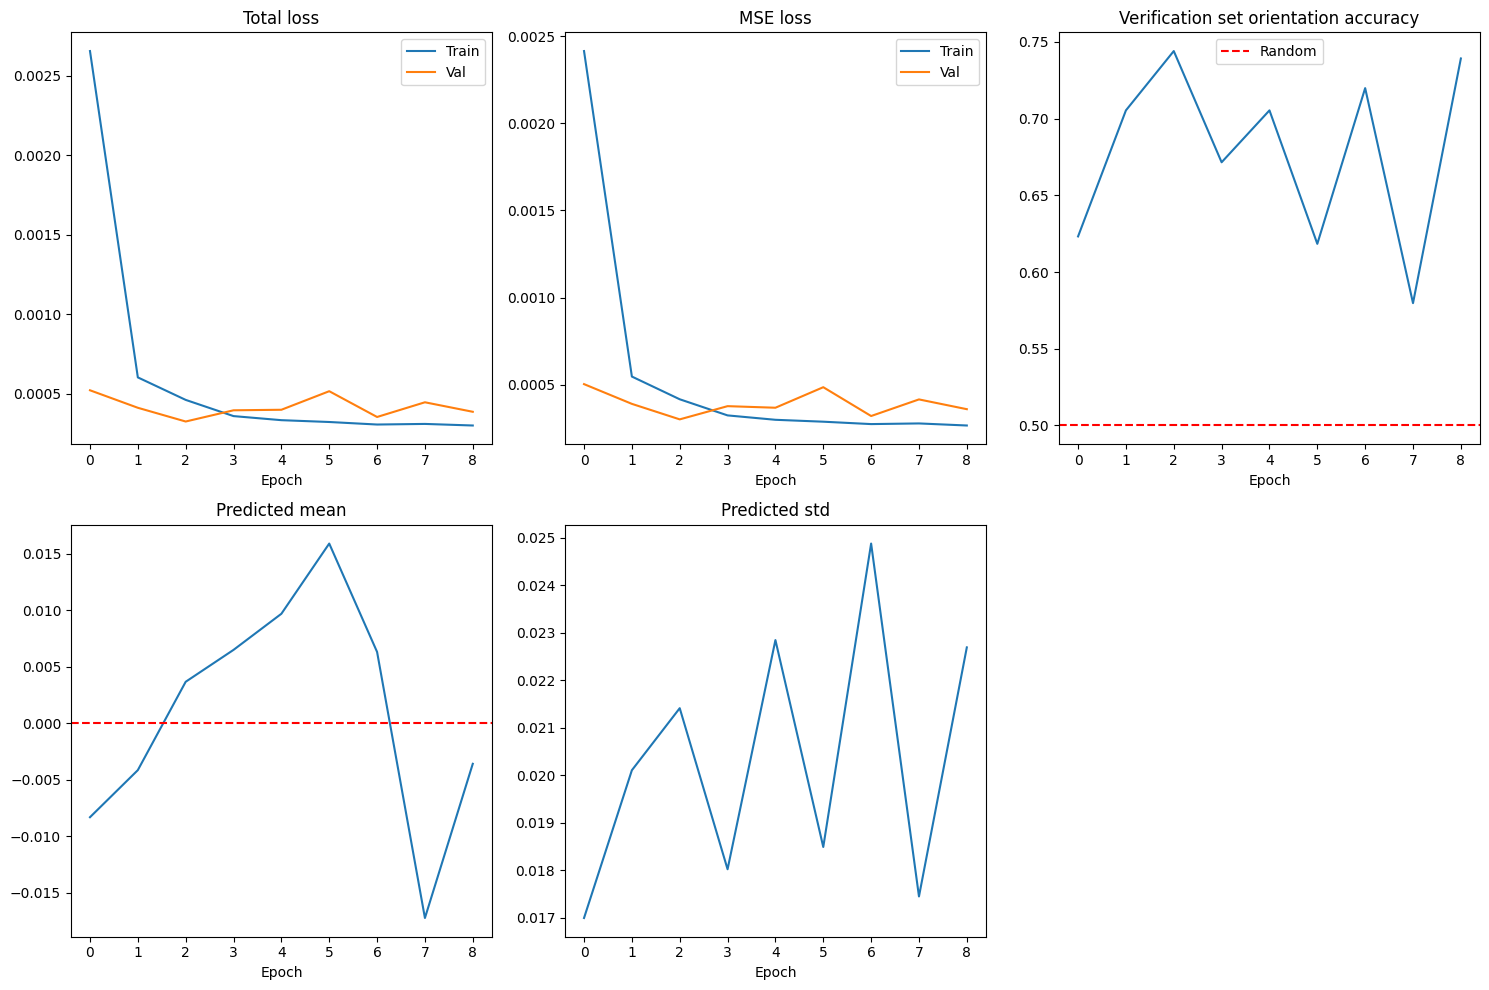

In [11]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 损失曲线
    axes[0, 0].plot(history['train_loss'], label='Train')
    axes[0, 0].plot(history['val_loss'], label='Val')
    axes[0, 0].set_title('Total loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    
    # MSE曲线
    axes[0, 1].plot(history['train_mse'], label='Train')
    axes[0, 1].plot(history['val_mse'], label='Val')
    axes[0, 1].set_title('MSE loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    
    # 方向准确率
    axes[0, 2].plot(history['val_direction_acc'])
    axes[0, 2].set_title('Verification set orientation accuracy')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].axhline(y=0.5, color='r', linestyle='--', label='Random')
    axes[0, 2].legend()
    
    # 预测均值
    axes[1, 0].plot(history['pred_mean'])
    axes[1, 0].set_title('Predicted mean')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    
    # 预测标准差
    axes[1, 1].plot(history['pred_std'])
    axes[1, 1].set_title('Predicted std')
    axes[1, 1].set_xlabel('Epoch')
    
    # 学习率（如果记录了的话）
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [12]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 准备测试数据
X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)

# 预测
with torch.no_grad():
    test_pred = model(X_test_t).cpu().numpy()

# ---- 评价 ----
print("=== 测试集结果 ===")
print(f"实际 - 均值: {y_test.mean():.6f},   标准差: {y_test.std():.6f}")
print(f"预测 - 均值: {test_pred.mean():.6f}, 标准差: {test_pred.std():.6f}")

mse  = mean_squared_error(y_test, test_pred)
mae  = mean_absolute_error(y_test, test_pred)
corr = np.corrcoef(y_test, test_pred)[0, 1]
direction_acc = (np.sign(y_test) == np.sign(test_pred)).mean()

print(f"\nMSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"相关系数: {corr:.4f}")
print(f"方向准确率: {direction_acc:.4f}")


=== 测试集结果 ===
实际 - 均值: 0.001469,   标准差: 0.023121
预测 - 均值: 0.005221, 标准差: 0.015589

MSE: 0.000291
MAE: 0.012630
相关系数: 0.6945
方向准确率: 0.7759


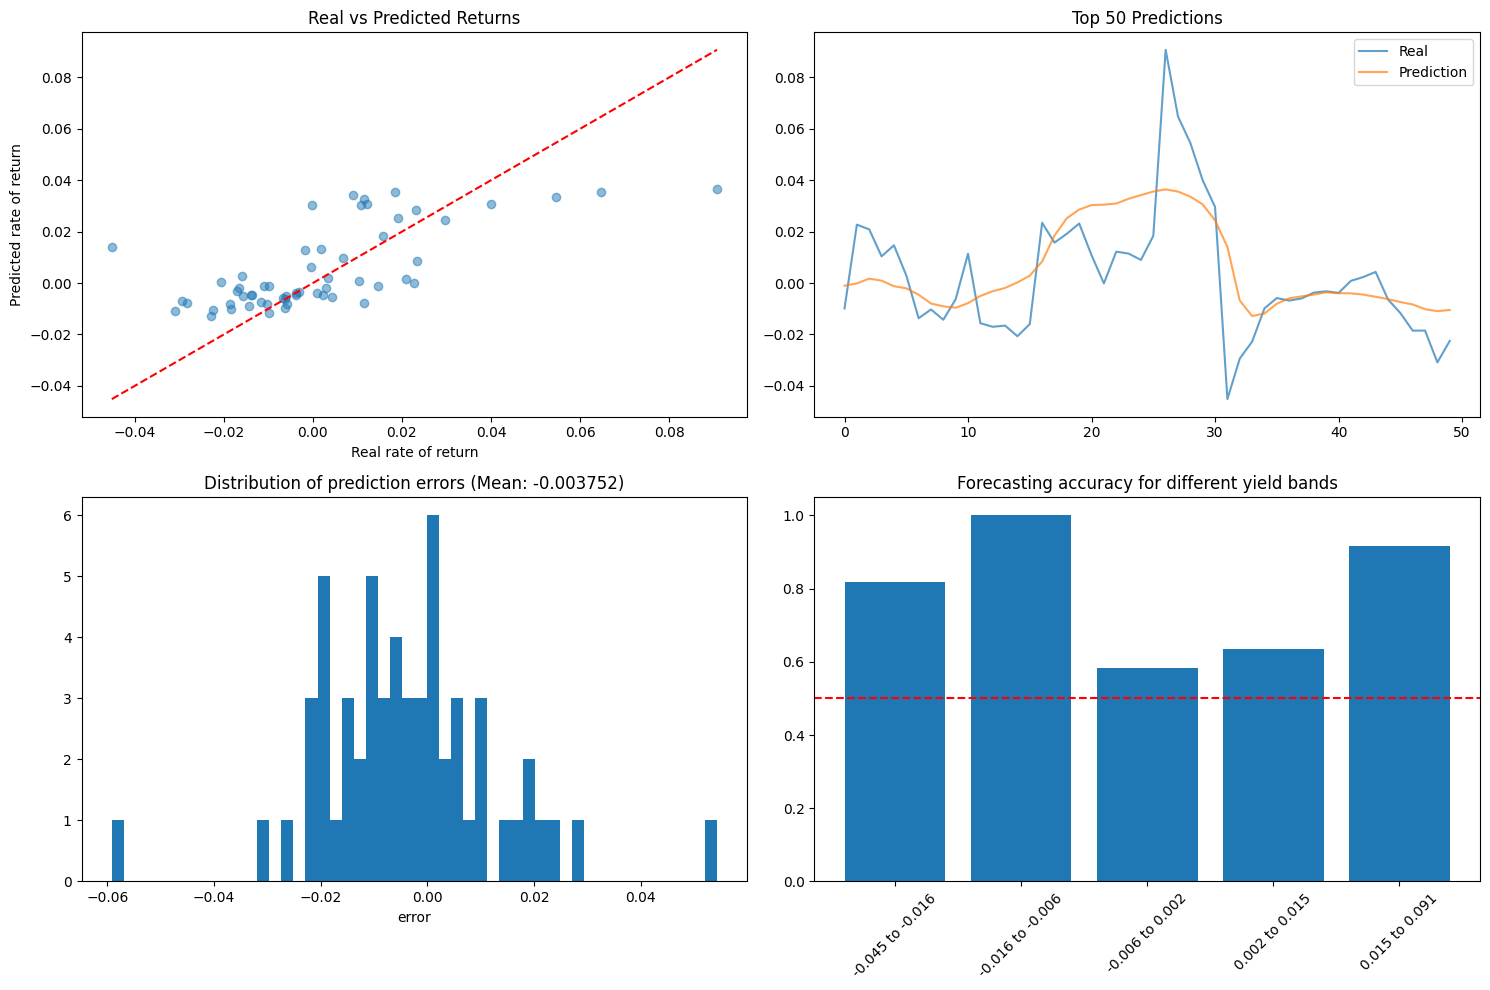

In [13]:
results_df = pd.DataFrame({
    'date': test_dates,
    'actual': y_test,
    'predicted': test_pred,
    'direction_correct': np.sign(y_test) == np.sign(test_pred)
})

# 可视化预测vs实际
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 散点图
axes[0, 0].scatter(y_test, test_pred, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_xlabel('Real rate of return')
axes[0, 0].set_ylabel('Predicted rate of return')
axes[0, 0].set_title('Real vs Predicted Returns')

# 时间序列对比
axes[0, 1].plot(results_df['actual'].values[:50], label='Real', alpha=0.7)
axes[0, 1].plot(results_df['predicted'].values[:50], label='Prediction', alpha=0.7)
axes[0, 1].legend()
axes[0, 1].set_title('Top 50 Predictions')

# 误差分布
errors = y_test - test_pred
axes[1, 0].hist(errors, bins=50)
axes[1, 0].set_title(f'Distribution of prediction errors (Mean: {errors.mean():.6f})')
axes[1, 0].set_xlabel('error')

# 按实际收益率大小分组的准确率
bins = np.percentile(y_test, [0, 20, 40, 60, 80, 100])
y_test_binned = pd.cut(y_test, bins=bins, duplicates='drop')
accuracy_by_bin = results_df.groupby(pd.cut(results_df['actual'], bins=bins, duplicates='drop'), observed=True)['direction_correct'].mean()

axes[1, 1].bar(range(len(accuracy_by_bin)), accuracy_by_bin.values)
axes[1, 1].set_xticks(range(len(accuracy_by_bin)))  # Set tick positions first
axes[1, 1].set_xticklabels([f'{bins[i]:.3f} to {bins[i+1]:.3f}' for i in range(len(bins)-1)], rotation=45)
axes[1, 1].set_title('Forecasting accuracy for different yield bands')
axes[1, 1].axhline(y=0.5, color='r', linestyle='--', label='Random')

plt.tight_layout()
plt.show()